In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pandas as pd
from scipy.spatial import distance_matrix
import numpy as np
import matplotlib.pyplot as plt
import itertools
import copy
from TrackReconstruction_functions import *


# hits = pd.read_hdf("/Users/mistryk2/Packages/nexus/ATPC_2nuBB_slim.h5","hits")

# hits = pd.read_hdf('../../NEXT_nudobe/files/data/Leptoquark_SM_nexus.h5',"MC/hits")
# hits = pd.read_hdf('../../NEXT_nudobe/files/data/Leptoquark_SM_1mm_smear.h5',"MC/hits")
# hits = pd.read_hdf('../../NEXT_nudobe/files/data/Leptoquark_SM_4mm_smear.h5',"MC/hits")

# hits = pd.read_hdf("/Users/mistryk2/Packages/nexus/ATPC_eminus_0.1mmstep_slim.h5","MC/hits")
# hits = pd.read_hdf("/Users/mistryk2/Packages/nexus/ATPC_eminus_0.1mmstep_slim_smear.h5","hits")
# hits = pd.read_hdf("/Users/mistryk2/Packages/nexus/ATPC_eminus_0.1mmstep_slim_smear_1mmbin.h5","hits")

# hits = pd.read_hdf("/Users/mistryk2/Packages/nexus/ATPC_eminus_1mmstep_high_E_slim_smear.h5","hits")


# hits = pd.read_hdf("../data/ATPC_gamma/ATPC_gamma_SF0_779551_24.h5", "hits")

# hits = pd.read_hdf("../../NEXT_nudobe/files/data/mbb_0_1mm_smear.h5", "MC/hits")

hits = pd.read_hdf("../data/ATPC_0nubb/ATPC_0nubb_smear_225.h5", "MC/hits")


# hits = pd.read_hdf("../data/ATPC_0nubb/ATPC_0nubb_SF0_779552_232.h5", "hits")

display(hits)


,event_id,x,y,z,energy
0,11300,-1442.772095,-482.059631,5283.557129,0.000075
1,11300,-1444.964355,-483.240204,5283.627441,0.001375
2,11300,-1440.086426,-480.735413,5283.657715,0.003825
3,11300,-1434.636597,-478.883301,5283.843750,0.001150
4,11300,-1449.957031,-486.046478,5283.895020,0.002300
...,...,...,...,...,...
27329,11326,-827.042603,-1937.431641,4143.975586,0.000300
27330,11326,-840.641418,-1931.412476,4144.221191,0.001300
27331,11326,-837.630249,-1932.569580,4144.608398,0.000075
27332,11326,-830.652161,-1935.606934,4144.857910,0.006875


,event_id,x,y,z,energy
0,11309,101.540314,-2106.661133,5193.264648,0.001150
1,11309,101.768814,-2104.225342,5191.881348,0.001875
2,11309,101.993378,-2108.905273,5196.624512,0.002175
3,11309,102.056450,-2074.336426,5164.591309,0.006650
4,11309,102.256721,-2074.810791,5161.917480,0.000575
...,...,...,...,...,...
1043,11309,1306.751221,-2483.698730,5319.378906,0.002275
1044,11309,1306.758423,-2489.484375,5314.683105,0.002225
1045,11309,1307.657715,-2486.747559,5318.047852,0.000475
1046,11309,1307.680176,-2488.681396,5316.722168,0.000825


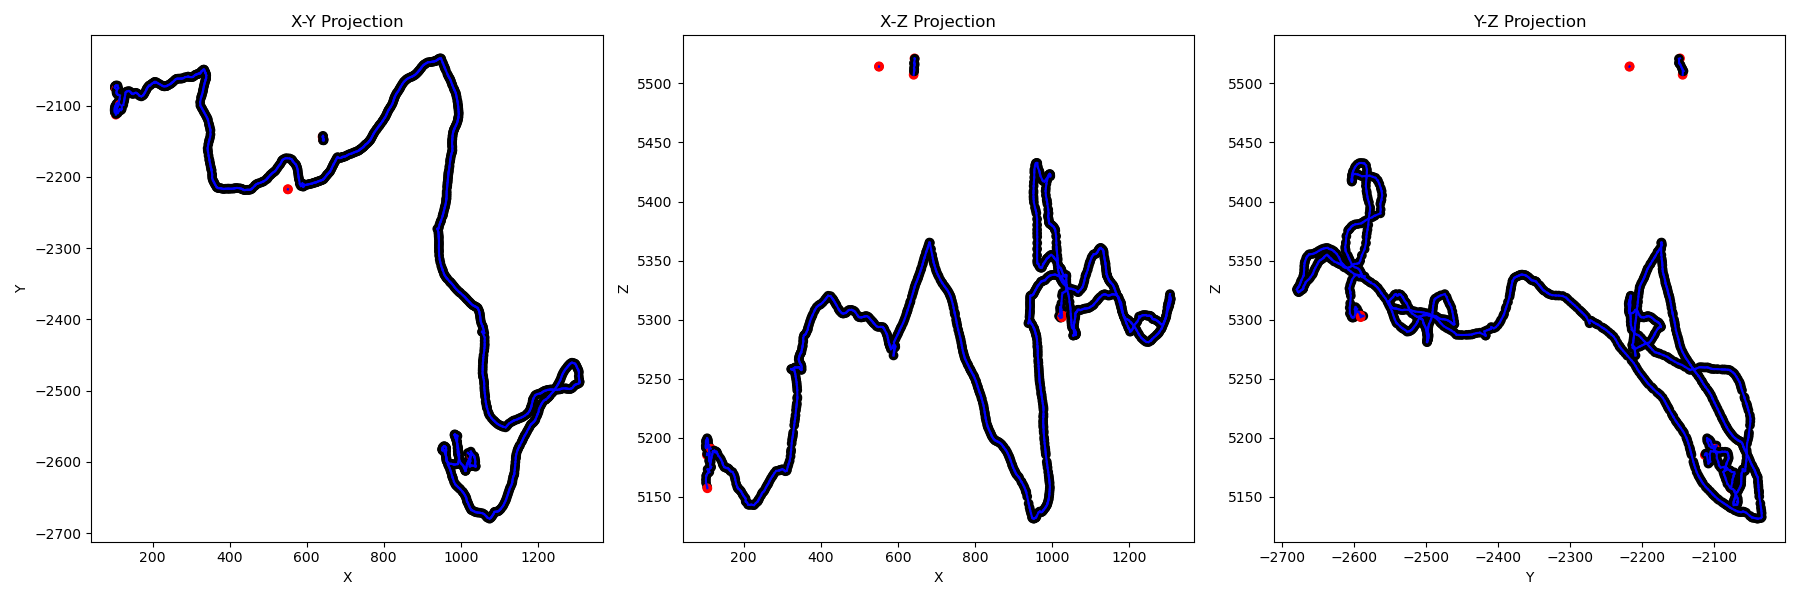

In [2]:
%matplotlib widget

data = hits[hits.event_id ==11309]

# There seems to be a duplicate row sometimes
data = data.drop_duplicates()

# display(data)
# eid = data.event_id.item()
data = data[['event_id', 'x', 'y', 'z',"energy"]]

# shuffle the data to ensure we dont use g4 ordering
data = data.sample(frac=1).reset_index(drop=True)

# then sort it based on the x,y,z
data = data.sort_values(by=['x', "y", "z"]).reset_index(drop=True)

display(data)

df = pd.DataFrame(data)

# Calculate the distance matrix
dist_matrix = distance_matrix(data[['x', 'y', 'z']], data[['x', 'y', 'z']])

# Initialize connections counter, keeps track of number of connections to each index
connection_count = np.zeros(len(data), dtype=int)

# This is a dict, format is
# index : [connected node 1, connected node 2,...]
connected_nodes = {}
connections = []

# Tunable parameters
init_dist_thresh = 15 # max distance for initial connections [mm]
incr_dist_thresh = [2,4,6,8,10,12,14,16,18,20] # Second stage, look for closest nodes, then slowly increase threshold [mm]
dist_threshold = 15 # Third distance threshold for conecting end nodes [mm]


for i in range(len(data)):
    # Find the index of the closest node (excluding itself)
    # closest_idx = np.argpartition(dist_matrix[i], 1)[1]
    closest_idx = np.argsort(dist_matrix[i])[1]
    
    # Check if the connection already exists 
    if closest_idx not in connected_nodes.get(i, []) and i not in connected_nodes.get(closest_idx, []):

        # Check the proposed node has 0 or 1 connection
        if (connection_count[closest_idx] <= 1 and connection_count[i] <= 1 and dist_matrix[i][closest_idx] < init_dist_thresh):
            
            cycle  = Testcycle(i, closest_idx ,connected_nodes, connections, connection_count)
            
            # Add connection between node i and closest_idx if it doesnt form a cycle
            if (not cycle):
                connected_nodes, connections, connection_count = UpdateConnections(i, closest_idx, connected_nodes, connections, connection_count)

# Get indices where the value is 1
single_nodes = np.where(connection_count == 1)[0]

# Incrementally loop over distance steps looking for connections
# starting from a small step size helps lock onto the nearest nodes
for dist in incr_dist_thresh:

    # Connect single nodes to the next closest single node
    for i in single_nodes:
        
        # Connections get updated, so this ensures we dont make a connection to a newly formed connection
        if connection_count[i] == 1:
            
            # Find the index of the closest node with one connection (excluding itself)
            sorted_indices = np.argsort(dist_matrix[i])[1:]
            
            for closest_idx in sorted_indices[:dist]:

                # Check if the index is not itelf and the connection count of the closest index is 1
                if closest_idx != i and connection_count[closest_idx] <= 1 and connection_count[i] <= 1 and closest_idx not in connected_nodes.get(i, []) and i not in connected_nodes.get(closest_idx, []): 
                    
                    if dist_matrix[i][closest_idx] < dist:

                        cycle  = Testcycle(i, closest_idx ,connected_nodes, connections, connection_count)
                        
                        if not cycle:
                            connected_nodes, connections, connection_count = UpdateConnections(i, closest_idx, connected_nodes, connections, connection_count)
                            break




# Function to plot connections
def plot_connections(ax, x, y, connections, connection_count, x_label, y_label):
    colors = ['r' if count == 1 or count == 0 else 'k' for count in connection_count]
    ax.scatter(x, y, c=colors, marker='o')
    for connection in connections:
        start_node = connection[0]
        end_node = connection[1]
        ax.plot([x[start_node], x[end_node]], [y[start_node], y[end_node]], 'b-')
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(f'{x_label}-{y_label} Projection')

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot xy projection
plot_connections(axs[0], data['x'], data['y'], connections, connection_count, 'X', 'Y')

# Plot xz projection
plot_connections(axs[1], data['x'], data['z'], connections, connection_count, 'X', 'Z')

# Plot yz projection
plot_connections(axs[2], data['y'], data['z'], connections, connection_count, 'Y', 'Z')

plt.tight_layout()
plt.show()

{'id': 0, 'start': 10, 'end': 754, 'nodes': [10, 11, 28, 31, 39, 40, 44, 45, 47, 46, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 128, 129, 131, 134, 136, 140, 142, 145, 148, 150, 152, 155, 157, 160, 161, 159, 158, 156, 153, 151, 149, 146, 144, 141, 139, 138, 135, 132, 130, 126, 127, 133, 137, 143, 147, 154, 162, 163, 166, 170, 173, 176, 180, 181, 182, 178, 174, 171, 168, 164, 165, 167, 169, 172, 175, 177, 179, 183, 184, 185, 186, 187, 189, 188, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 24

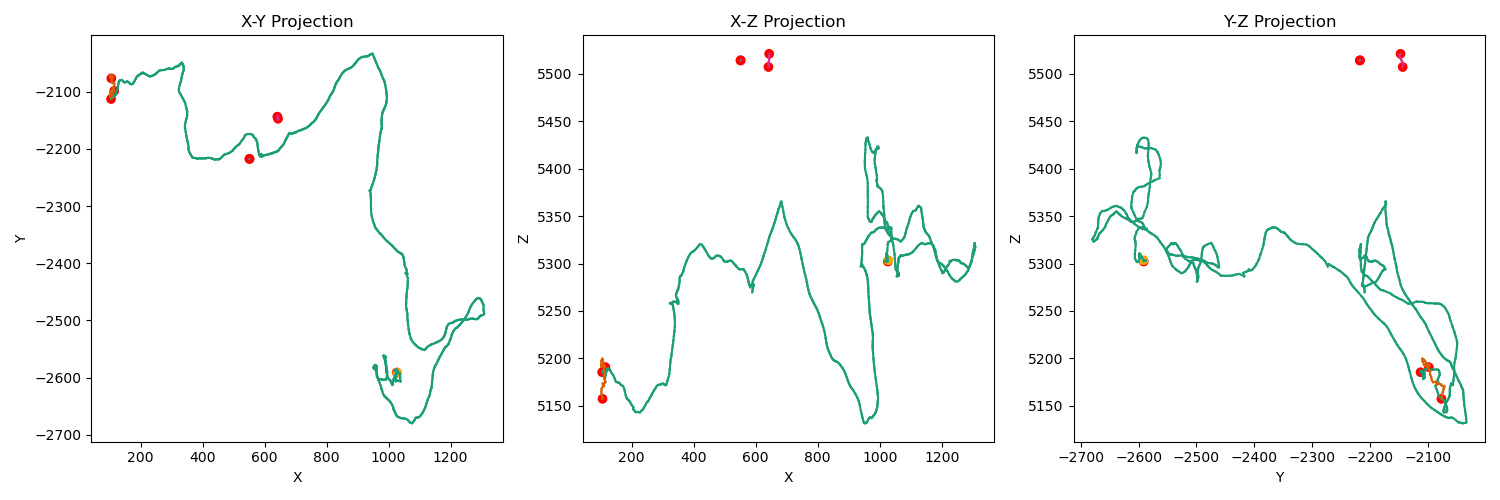

In [3]:
# Track building
colormap = plt.cm.get_cmap('Dark2')
color_cycle = itertools.cycle(colormap.colors)

# Get indices where the value is 1
single_nodes = np.where(connection_count == 1)[0]

Tracks = []

for i,node in enumerate(single_nodes):
    # Check that the track hasnt already been added
    if (check_start_end_exists(node,Tracks)):
        continue

    # Get the track path
    path = GetNodePath(connected_nodes, node, connected_nodes[node][0])

    total_length, total_energy = GetTrackLengthEnergy(path, data)
    color = next(color_cycle)

    Track = {"id":i, "start":path[0], "end":path[-1], "nodes":path, "length":total_length, "energy":total_energy,"label":"track","c":color}
    Tracks.append(Track)


for t in Tracks:
    print(t)

# Function to plot connections
def plot_tracks(ax, x, y, connection_count, x_label, y_label, Tracks_):
    # Filter data for markers with count 1 or 0
    filtered_indices = [i for i, count in enumerate(connection_count) if count == 1 or count == 0 or count == 3]
    filtered_x = [x[i] for i in filtered_indices]
    filtered_y = [y[i] for i in filtered_indices]
    
    # # Define colors for filtered data
    colors = [None] * len(filtered_indices)
    for index, i in enumerate(filtered_indices):
        if connection_count[i] == 1:
            colors[index] = "r"
        elif (connection_count[i] == 0):
            colors[index] = "Orange"
        else:
            colors[index] = "DarkGreen"

    
    # Plot filtered markers
    ax.scatter(filtered_x, filtered_y, c=colors, marker='o')

    # Plot connections
    for Track in Tracks_:
        for i, connection in enumerate(Track["nodes"]):
            if i == len(Track["nodes"]) - 1:
                break

            start_node = Track["nodes"][i]
            end_node = Track["nodes"][i + 1]

            ax.plot([x[start_node], x[end_node]],
                    [y[start_node], y[end_node]], color=Track["c"], linestyle="-")
            
        if (Track["label"] == "vertex"):
            ax.plot(x[Track["start"]], y[Track["start"]], marker = "x", color = "r" )
    
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(f'{x_label}-{y_label} Projection')


# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot xy projection
plot_tracks(axs[0], data['x'], data['y'], connection_count, 'X', 'Y', Tracks)

# Plot xz projection
plot_tracks(axs[1], data['x'], data['z'], connection_count, 'X', 'Z', Tracks)

# Plot yz projection
plot_tracks(axs[2], data['y'], data['z'], connection_count, 'Y', 'Z', Tracks)

plt.tight_layout()
plt.show()

In [4]:
print(GetMeanNodeDist(Tracks, data))

dist_threshold = 4*GetMeanNodeDist(Tracks, data)

3.269


In [5]:
# Now look to merge tracks that are close by and identify deltas

# Add in any nodes without connections to the tracks as gammas and re-label other tracks as gammas
AddConnectionlessNodes(connection_count, Tracks, data)


In [6]:

finished = False  # Initial state

q = 0
while not finished:
    print("Loop: ", q)
    # finished, Tracks2 = ConnectTracks(Tracks2, temp_connections_dict, temp_connections, temp_connection_count)
    finished, Tracks, connected_nodes, connections, connection_count = ConnectTracks(Tracks, connected_nodes, connections, connection_count, dist_matrix, dist_threshold, data)
    q=q+1

print(finished)

print("Total Tracks:", len(Tracks))

for t in Tracks:
    print(t)



Loop:  0
Loop:  1
Loop:  2
True
Total Tracks: 4
{'id': 3, 'start': 256, 'end': 257, 'nodes': [256, 257], 'length': 0.572, 'energy': 0.029800000600516796, 'label': 'track', 'c': (0.4588235294117647, 0.4392156862745098, 0.7019607843137254)}
{'id': 5, 'start': 306, 'end': 315, 'nodes': [306, 308, 309, 312, 307, 316, 314, 310, 311, 317, 315], 'length': 19.43, 'energy': 0.07764999855135102, 'label': 'track', 'c': (0.9058823529411765, 0.1607843137254902, 0.5411764705882353)}
{'id': 8, 'start': 46, 'end': 10, 'nodes': [46, 47, 45, 44, 40, 39, 31, 28, 11, 10], 'length': 34.938, 'energy': 0.12142500060144812, 'label': 'track', 'c': 'black'}
{'id': 9, 'start': 15, 'end': 761, 'nodes': [15, 13, 4, 3, 7, 9, 14, 25, 33, 24, 21, 17, 19, 29, 32, 43, 41, 38, 37, 36, 35, 34, 30, 27, 23, 22, 18, 12, 5, 2, 0, 1, 6, 8, 16, 20, 26, 42, 46, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 9

True


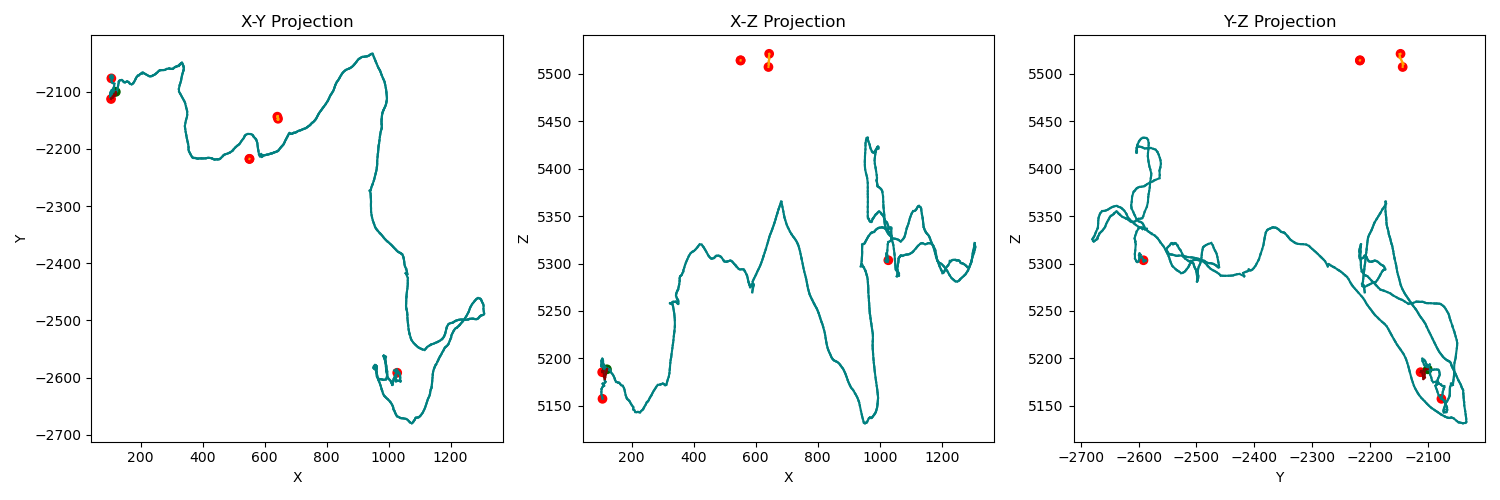

In [7]:

RebuiltTrack, pass_flag = RebuildTracks(connected_nodes, connection_count, data)

print(pass_flag)


# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot xy projection
plot_tracks(axs[0], data['x'], data['y'], connection_count, 'X', 'Y', RebuiltTrack)

# Plot xz projection
plot_tracks(axs[1], data['x'], data['z'], connection_count, 'X', 'Z', RebuiltTrack)

# Plot yz projection
plot_tracks(axs[2], data['y'], data['z'], connection_count, 'Y', 'Z', RebuiltTrack)

plt.tight_layout()
plt.show()



In [8]:
# Re-Color the tracks
Tracks = CategorizeTracks(Tracks)


In [9]:
for c in connection_count:
    if (c>2):print(c)

3


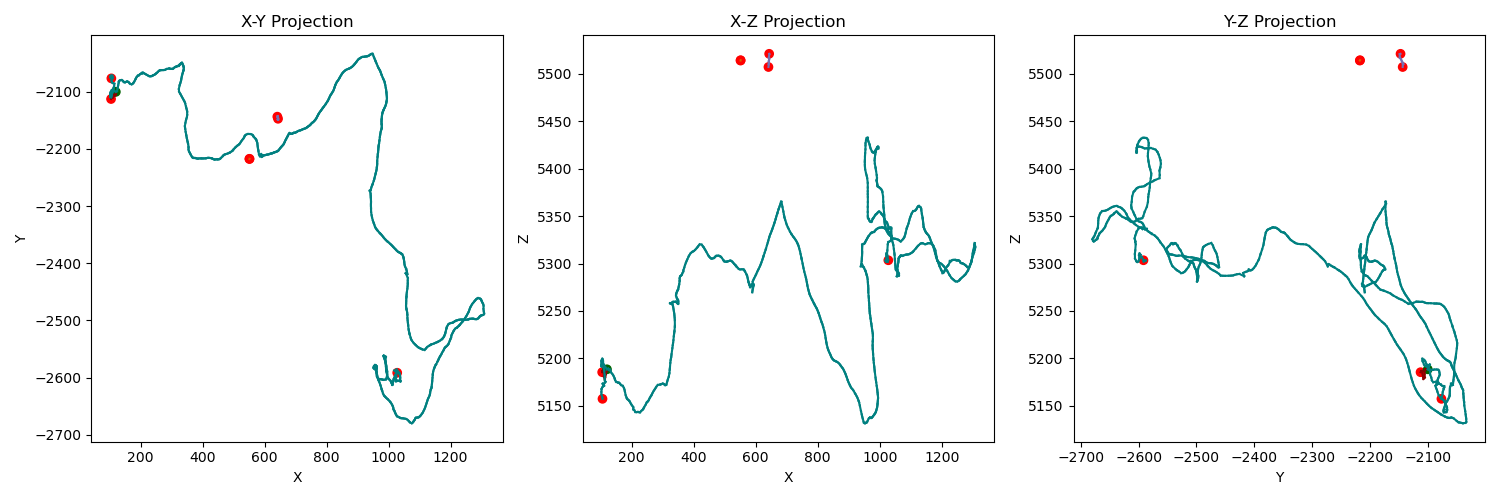

In [10]:
# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot xy projection
plot_tracks(axs[0], data['x'], data['y'], connection_count, 'X', 'Y', Tracks)

# Plot xz projection
plot_tracks(axs[1], data['x'], data['z'], connection_count, 'X', 'Z', Tracks)

# Plot yz projection
plot_tracks(axs[2], data['y'], data['z'], connection_count, 'Y', 'Z', Tracks)

plt.tight_layout()
plt.show()

In [11]:
for i in connected_nodes:
    [print(connected_nodes[i])]

[1, 2]
[0, 6]
[1, 8]
[5, 0]
[2, 12]
[4, 7]
[3, 13]
[6, 16]
[9, 3]
[7, 14]
[11]
[10, 28]
[5, 18]
[15, 4]
[13]
[9, 25]
[20, 8]
[16, 26]
[19, 21]
[17, 29]
[22, 12]
[18, 23]
[24, 17]
[21, 33]
[22, 27]
[14, 33]
[20, 42]
[23, 30]
[11, 31]
[32, 19]
[29, 43]
[34, 27]
[30, 35]
[39, 28]
[31, 40]
[24, 25]
[34, 36]
[37, 35]
[36, 38]
[37, 41]
[39, 44]
[38, 43]
[41, 32]
[45, 40]
[44, 47]
[45, 46]
[48, 47, 42]
[46, 49]
[50, 48]
[49, 51]
[50, 52]
[53, 51]
[52, 54]
[53, 55]
[54, 56]
[57, 55]
[56, 58]
[59, 57]
[58, 60]
[59, 61]
[62, 60]
[61, 63]
[64, 62]
[63, 65]
[66, 64]
[65, 67]
[66, 68]
[69, 67]
[68, 70]
[69, 71]
[70, 72]
[71, 73]
[74, 72]
[73, 75]
[74, 76]
[75, 77]
[78, 76]
[77, 79]
[80, 78]
[79, 81]
[82, 80]
[81, 83]
[82, 84]
[83, 85]
[84, 86]
[85, 87]
[86, 88]
[87, 89]
[90, 88]
[89, 91]
[90, 92]
[93, 91]
[92, 94]
[93, 95]
[94, 96]
[97, 95]
[96, 98]
[99, 97]
[98, 100]
[99, 101]
[102, 100]
[101, 103]
[104, 102]
[103, 105]
[104, 106]
[107, 105]
[106, 108]
[107, 109]
[108, 110]
[109, 111]
[112, 110]
[

In [12]:
# Get the track with the most nodes, this is taken to be the primary

num_nodes = 0
primary_track_id = -1
primary_nodes = []

for t in Tracks:
    if ( len(t["nodes"]) > num_nodes):
        num_nodes = len(t["nodes"])
        primary_track_id = t["id"]
        primary_nodes = t["nodes"]

print("The primary track is: ", primary_track_id)

# This list makes sure we only have one angle per node
all_visited = []

Primary_Track = data.reindex(primary_nodes)
Primary_Track = GetAnglesDF(Primary_Track, all_visited, 1, primary_track_id)
all_visited = all_visited + primary_nodes

df_angles = pd.DataFrame()
df_angles = pd.concat([df_angles, Primary_Track], ignore_index=True)

for t in Tracks:

    trk_nodes = t["nodes"]
    if t["id"] == primary_track_id:
        continue
    else:
        
        # See if the first/last node has three connections. If it does then flip the track
        con_end = connection_count[t["nodes"][-1]]
        if (con_end == 3):
            trk_nodes = trk_nodes[::-1]
        
        trk = data.reindex(trk_nodes)

        trk = GetAnglesDF(trk, all_visited, 0, t["id"])
        all_visited = all_visited + trk_nodes
        df_angles = pd.concat([df_angles, trk], ignore_index=True)


# Primary_Track.reset_index(drop=True, inplace=True)
pd.set_option('display.max_rows', 100)
display(df_angles[df_angles.trkID ==5])

print(connected_nodes)



The primary track is:  9


,event_id,x,y,z,energy,id,primary,trkID,cumulative_distance,angle
1028,11309,640.967346,-2143.593994,5507.319336,0.004950,306,0,5,0.000000,0.000000
1029,11309,642.070862,-2143.327881,5510.317871,0.005325,308,0,5,3.206209,157.736271
1030,11309,642.175293,-2142.481934,5510.504395,0.000250,309,0,5,4.078748,71.240999
1031,11309,642.530701,-2143.919922,5512.116211,0.001475,312,0,5,6.267829,117.389756
1032,11309,642.002136,-2144.907959,5513.263672,0.005475,307,0,5,7.871657,28.603168
1033,11309,643.361938,-2146.553711,5515.512207,0.003575,316,0,5,10.972217,45.468166
1034,11309,643.215454,-2147.864014,5516.724121,0.000675,314,0,5,12.763051,32.514029
1035,11309,642.404480,-2148.474365,5517.129883,0.000675,310,0,5,13.856143,43.909447
1036,11309,642.485535,-2148.567383,5517.544434,0.000200,311,0,5,14.288664,70.316053
1037,11309,643.774231,-2148.758301,5520.836426,0.023825,317,0,5,17.829060,13.828550


{0: [1, 2], 1: [0, 6], 6: [1, 8], 2: [5, 0], 5: [2, 12], 3: [4, 7], 4: [3, 13], 8: [6, 16], 7: [9, 3], 9: [7, 14], 10: [11], 11: [10, 28], 12: [5, 18], 13: [15, 4], 15: [13], 14: [9, 25], 16: [20, 8], 20: [16, 26], 17: [19, 21], 19: [17, 29], 18: [22, 12], 22: [18, 23], 21: [24, 17], 24: [21, 33], 23: [22, 27], 25: [14, 33], 26: [20, 42], 27: [23, 30], 28: [11, 31], 29: [32, 19], 32: [29, 43], 30: [34, 27], 34: [30, 35], 31: [39, 28], 39: [31, 40], 33: [24, 25], 35: [34, 36], 36: [37, 35], 37: [36, 38], 38: [37, 41], 40: [39, 44], 41: [38, 43], 43: [41, 32], 44: [45, 40], 45: [44, 47], 47: [45, 46], 46: [48, 47, 42], 48: [46, 49], 49: [50, 48], 50: [49, 51], 51: [50, 52], 52: [53, 51], 53: [52, 54], 54: [53, 55], 55: [54, 56], 56: [57, 55], 57: [56, 58], 58: [59, 57], 59: [58, 60], 60: [59, 61], 61: [62, 60], 62: [61, 63], 63: [64, 62], 64: [63, 65], 65: [66, 64], 66: [65, 67], 67: [66, 68], 68: [69, 67], 69: [68, 70], 70: [69, 71], 71: [70, 72], 72: [71, 73], 73: [74, 72], 74: [73, 75

Text(0, 0.5, 'Scatter Angle [deg]')

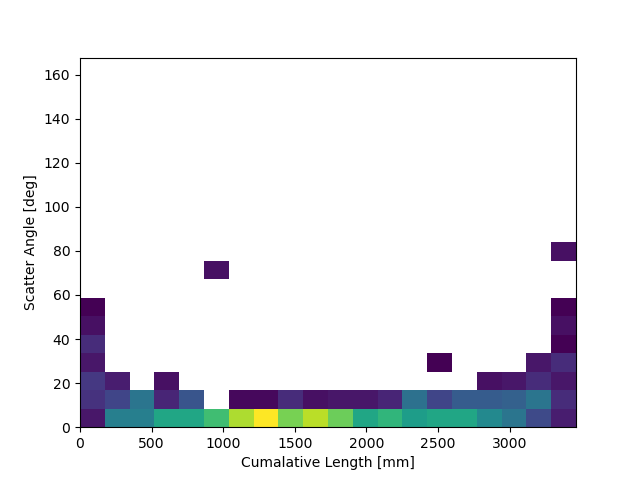

In [13]:
plt.figure()
# plt.scatter(Primary_Track.x, Primary_Track.z)

# plt.scatter(Primary_Track.index, Primary_Track.angle)

# plt.hist(Primary_Track.angle)
# plt.semilogy()
plt.hist2d(Primary_Track.cumulative_distance, Primary_Track.angle, bins = 20,cmin=3);

# plt.scatter(Primary_Track.cumulative_distance, Primary_Track.angle);

# plt.scatter(Primary_Track.cumulative_distance, Primary_Track.angle)

plt.xlabel("Cumalative Length [mm]")
plt.ylabel("Scatter Angle [deg]")

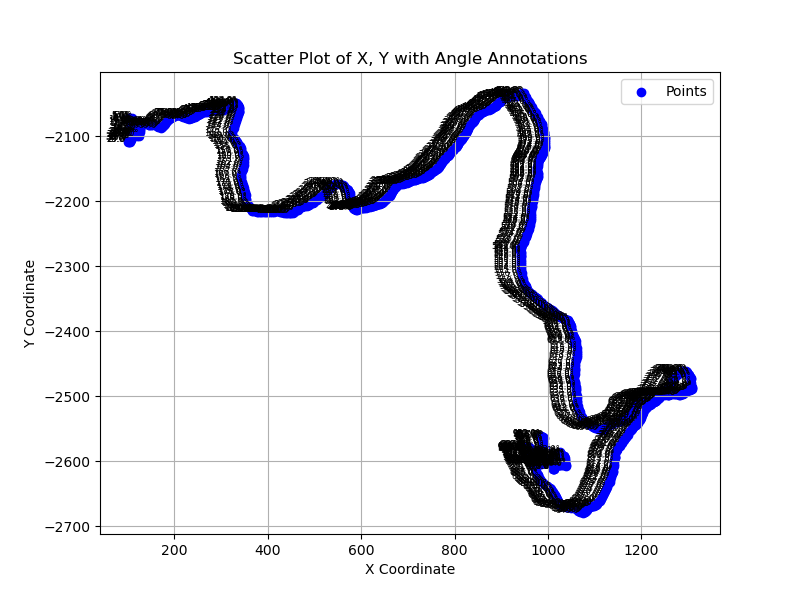

In [14]:
# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(Primary_Track['x'], Primary_Track['y'], color='blue', label='Points')

# Annotate each point with the corresponding angle
for i in range(len(Primary_Track)):
    x = Primary_Track.iloc[i]['x']
    y = Primary_Track.iloc[i]['y']
    # angle = Primary_Track.loc[i, 'angle']
    angle = i
    
    # Only annotate if angle is not NaN
    if not np.isnan(angle):
        plt.text(x, y, f'{angle:.1f}°', fontsize=6, ha='right')

# Additional plot settings
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Scatter Plot of X, Y with Angle Annotations')
plt.legend()
plt.grid(True)

# Show plot
plt.show()